In [244]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

- Has the yield improved over time?
- Has the mix of crops changed over the years?
- Does crop price for a year affect production the following year?
- Which are the richest Counties or State?
- How are unemployment rate affect Yield or production especially for small, medium, large areas? or are they even related?
- Are there regions in the country that produce the most? (region could be across state lines)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

sns.set(rc={'figure.figsize':(15,8)},style="ticks")

<b>Column Units</b><br>
Year = Year represented as Jan 01 for that Year.<br>
Acres Harvested = Acres<br>
Production = Pounds (lbs)<br>
Yield = Pounds/Acre (lbs/acre)<br>
Price = \$ (USD)<br>
Yearly Unemployment Rate = Percent of unemployed<br>

In [21]:
clean_data_file = 'Data/Crop_Pivoted.xlsx'
data_df = pd.read_excel(clean_data_file,sheet_name='Crop Data',parse_dates=['Year'],dtype={'State':'category', 'CROP':'category', 'County':'category'})
data_df.head()

,CROP,Year,State,County,ACRES HARVESTED,PRODUCTION,YIELD,PRICE,Yearly Unemployment Rate
0,CORN,1984-01-01,ALABAMA,AUTAUGA,2500,5768000,2307.200000,0.050893,11.0
1,CORN,1984-01-01,ALABAMA,BALDWIN,40700,178976000,4397.444717,0.050893,11.0
2,CORN,1984-01-01,ALABAMA,BARBOUR,7700,24304000,3156.363636,0.050893,11.0
3,CORN,1984-01-01,ALABAMA,BLOUNT,2200,6944000,3156.363636,0.050893,11.0
4,CORN,1984-01-01,ALABAMA,BULLOCK,2000,6048000,3024.000000,0.050893,11.0


#### Has the yield improved over time?
The general trend for yield has been up, especially for Corn. The barley yield has been rather steady in recent years, and has fallen during 2017.

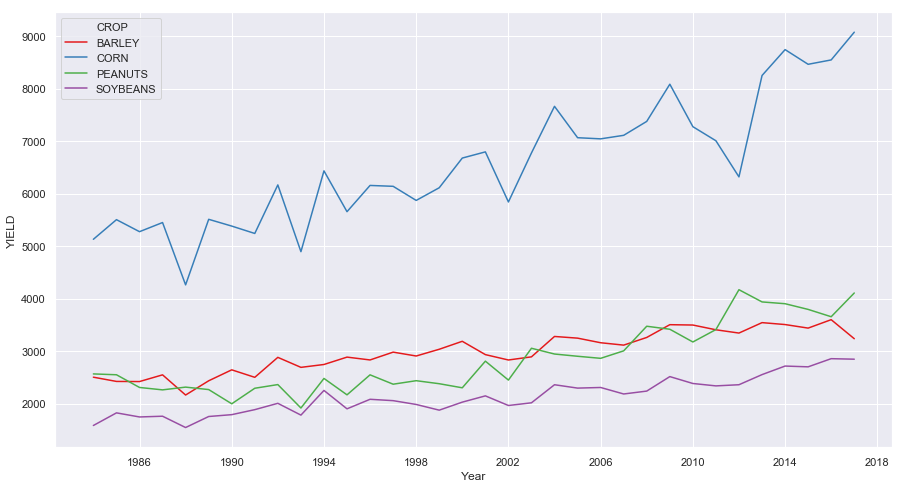

In [123]:
sns.lineplot(x='Year',y='YIELD',hue='CROP',palette='Set1',data=data_df.groupby(['Year','CROP']).mean().reset_index())
plt.show()

#### Has the mix of crops changed over the years?
Although the over all production has increased, but looks like Corn and Soybeans have taken over the production. There seem to be big drop in total production during the years 1988, 1993, 1995 and to some extent in 2012. And this drop is mostly in corn. (need to investigate)

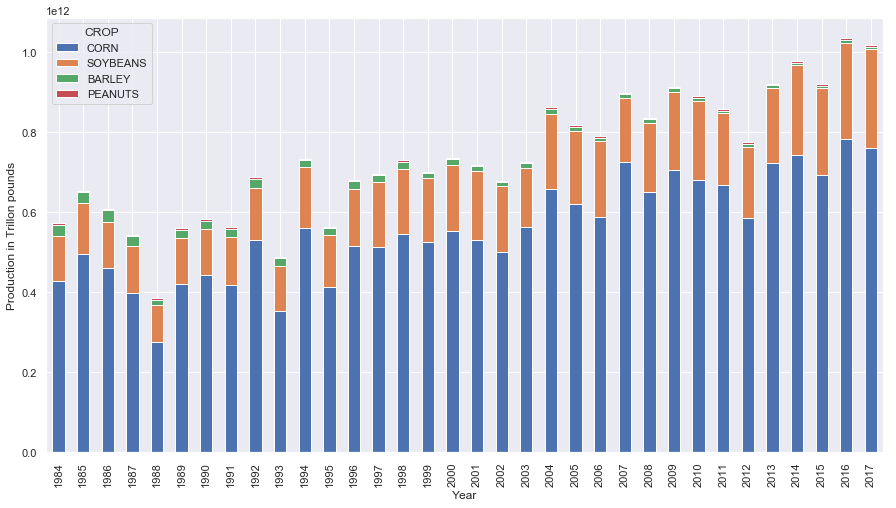

In [175]:
yearly_crop_df = data_df.groupby(['Year','CROP'])['PRODUCTION'].sum().reset_index()
year_crop_flat = yearly_crop_df.pivot_table(index='Year',columns='CROP',values='PRODUCTION').fillna(0)[['CORN', 'SOYBEANS','BARLEY', 'PEANUTS']]
ax = year_crop_flat.plot(kind='bar',stacked=True)
index_df = year_crop_flat.index.to_frame(index=False) 
year_crop_flat = year_crop_flat.reset_index(drop=True) 
year_crop_flat = pd.merge(index_df, year_crop_flat, left_index=True, right_index=True)
x_year = year_crop_flat['Year'].dt.strftime('%Y').sort_values().unique()
ax.xaxis.set_major_formatter(plt.FixedFormatter(x_year))
plt.ylabel('Production in Trillon pounds')
plt.show()

#### Does crop price for a year affect production the following year?
From the scatter plot below, generally there is very loss relation between previous prices on following year production or yield. But the degree of lossness vary from crop to crop, with peanuts production least tide to prices where as corn is relatively tight. The interesting case of Barley where production and yield show opposite reaction to previous year pricing.

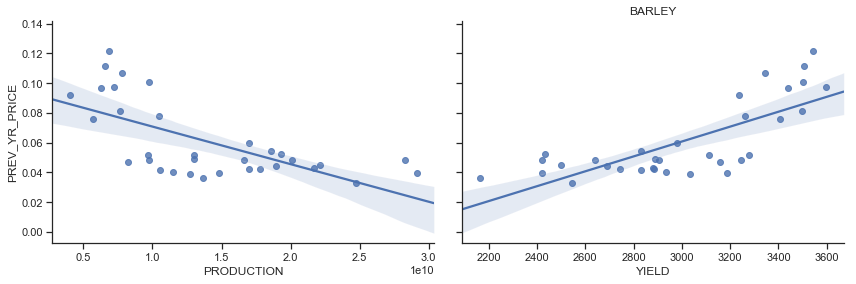

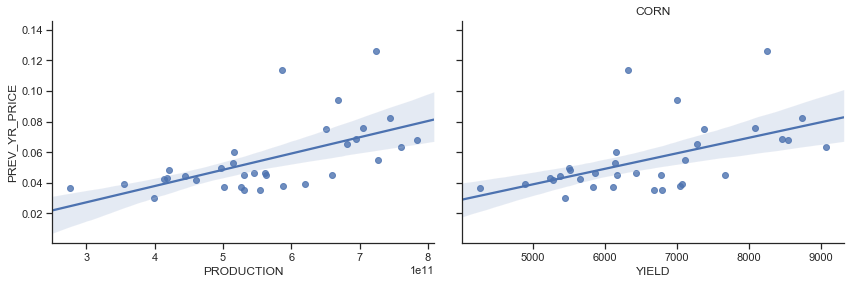

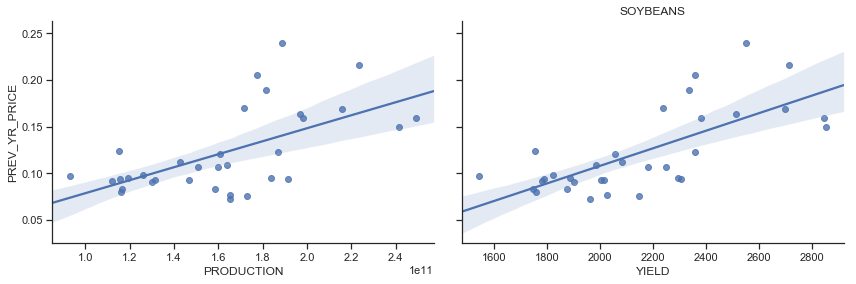

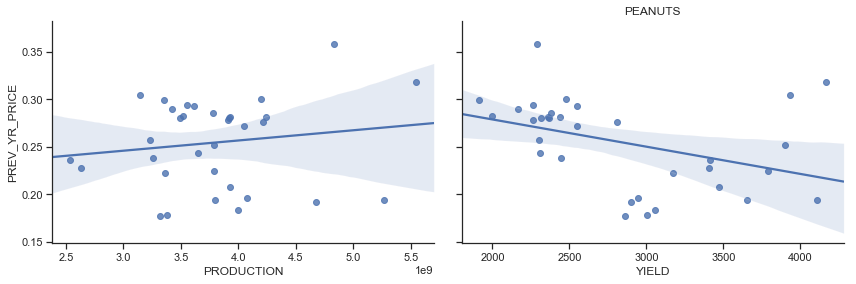

In [215]:
yearly_data_df = data_df.groupby(['Year','CROP']).agg({'PRODUCTION':'sum','YIELD':'mean','PRICE':'mean'})
yearly_data_df.loc[:,'PREV_YR_PRICE'] = yearly_data_df.groupby(['CROP'])['PRICE'].shift(1)
yearly_data_df = yearly_data_df.dropna(axis=0,how='any')
sns.pairplot(yearly_data_df.loc[(slice(None),'BARLEY'),['PRODUCTION','YIELD','PREV_YR_PRICE']],x_vars=['PRODUCTION','YIELD'],y_vars='PREV_YR_PRICE',kind='reg',height=4, aspect=1.5)
plt.title('BARLEY')
sns.pairplot(yearly_data_df.loc[(slice(None),'CORN'),['PRODUCTION','YIELD','PREV_YR_PRICE']],x_vars=['PRODUCTION','YIELD'],y_vars='PREV_YR_PRICE',kind='reg',height=4, aspect=1.5)
plt.title('CORN')
sns.pairplot(yearly_data_df.loc[(slice(None),'SOYBEANS'),['PRODUCTION','YIELD','PREV_YR_PRICE']],x_vars=['PRODUCTION','YIELD'],y_vars='PREV_YR_PRICE',kind='reg',height=4, aspect=1.5)
plt.title('SOYBEANS')
sns.pairplot(yearly_data_df.loc[(slice(None),'PEANUTS'),['PRODUCTION','YIELD','PREV_YR_PRICE']],x_vars=['PRODUCTION','YIELD'],y_vars='PREV_YR_PRICE',kind='reg',height=4, aspect=1.5)
plt.title('PEANUTS')
plt.show()

#### Which are the richest Counties or State?
There are no surprises in the top 10 states by production value, with top stop to Iowa and second to Illinois. But when you look at counties most of the Top 10 counties are from Illinois. Which could mean that few counties in Illinois account for most of the production and for Iowa there are many averagely performing counties.

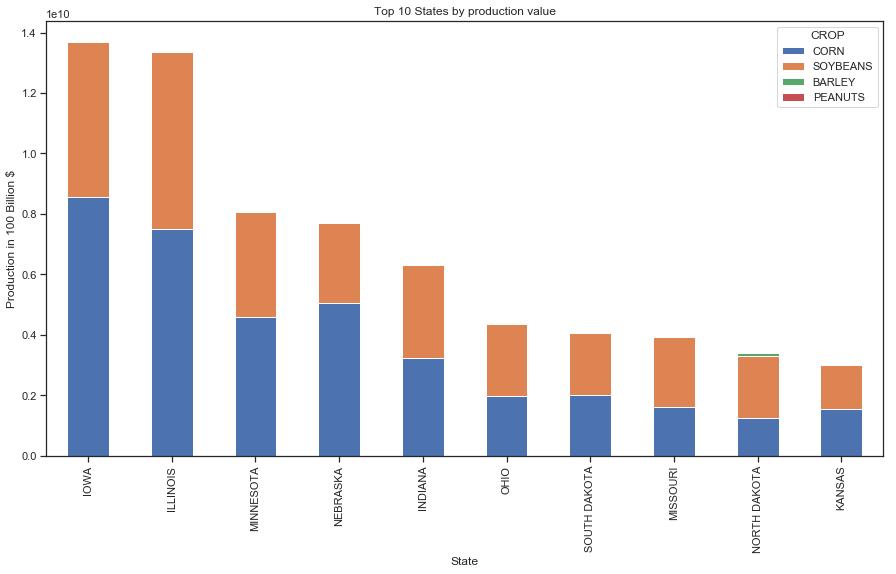

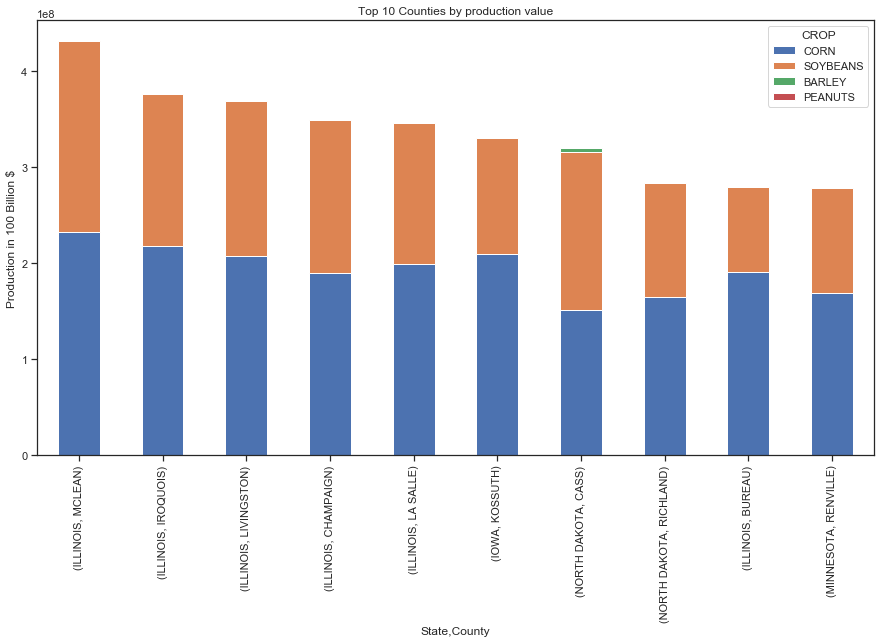

In [242]:
df_money=data_df.copy()
df_money['Sale'] = data_df['PRODUCTION']*data_df['PRICE']

df_money_state = df_money.loc[df_money['Year'].dt.year==2017,:].groupby(['State','CROP']).sum().reset_index()
df_state_stacked = df_money_state.pivot_table(index='State',columns='CROP',values='Sale').fillna(0)[['CORN', 'SOYBEANS','BARLEY', 'PEANUTS']]
df_state_stacked.columns = df_state_stacked.columns.add_categories('Total Sale')
df_state_stacked.loc[:,'Total Sale']=df_state_stacked['CORN']+df_state_stacked['BARLEY']+df_state_stacked['PEANUTS']+df_state_stacked['SOYBEANS']
df_state_stacked = df_state_stacked.sort_values(by='Total Sale',ascending=False).head(10).drop(columns='Total Sale')
df_state_stacked.plot(kind='bar',stacked=True)
plt.ylabel('Production in 100 Billion $')
plt.title('Top 10 States by production value')

df_money_county = df_money.loc[df_money['Year'].dt.year==2017,:].groupby(['State','County','CROP']).sum().reset_index()
df_county_stacked = df_money_county.pivot_table(index=['State','County'],columns='CROP',values='Sale').fillna(0)[['CORN', 'SOYBEANS','BARLEY', 'PEANUTS']]
df_county_stacked.columns = df_county_stacked.columns.add_categories('Total Sale')
df_county_stacked.loc[:,'Total Sale']=df_county_stacked['CORN']+df_county_stacked['BARLEY']+df_county_stacked['PEANUTS']+df_county_stacked['SOYBEANS']
df_county_stacked = df_county_stacked.sort_values(by='Total Sale',ascending=False).head(10).drop(columns=['Total Sale'])
df_county_stacked.plot(kind='bar',stacked=True)
plt.ylabel('Production in 100 Billion $')
plt.title('Top 10 Counties by production value')
plt.show()

#### How are unemployment rate affect Yield or production especially for small, medium, large areas? or are they even related?
Looks like there is no relation between unemployment rate and production or yield. But this data shows in information that would have otherwise be hidden, there is no large scale production of peanuts. Why would this be? could it be the price or the profit margins?

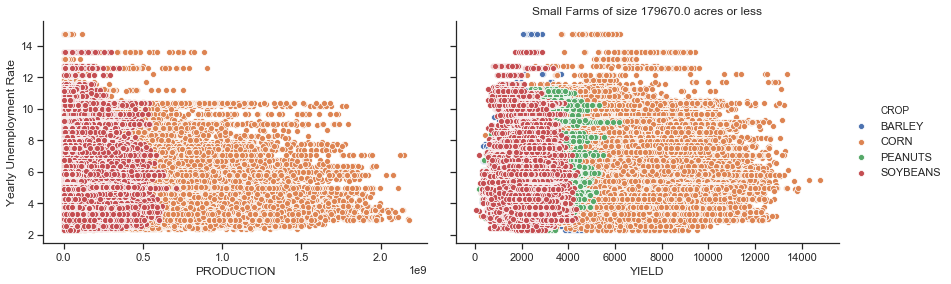

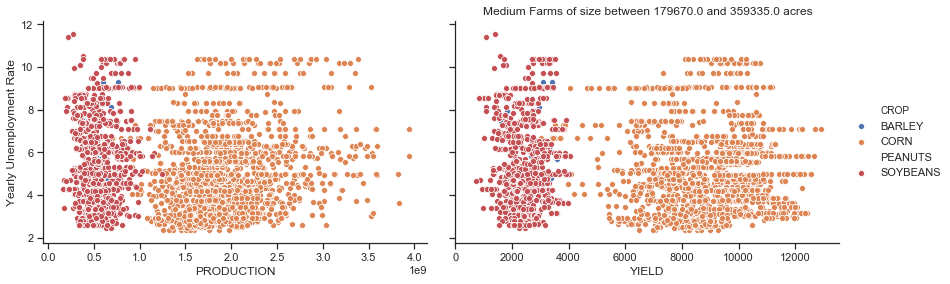

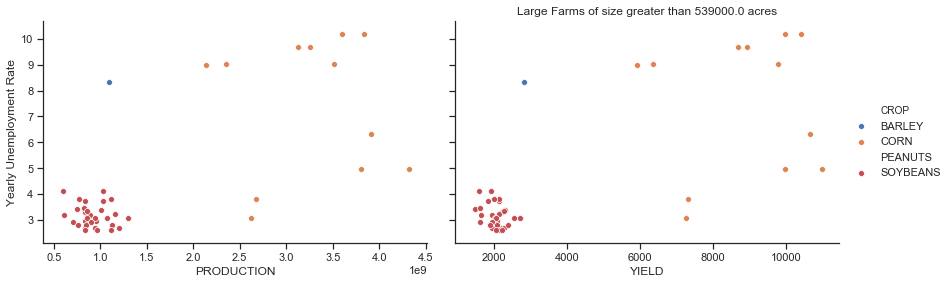

In [296]:
cat_df = data_df.copy()
cat_df['ACRES HARVESTED - Size'], bins = pd.cut(data_df['ACRES HARVESTED'],bins=3, labels=['small', 'medium', 'large'], retbins=True)
cat_df = cat_df[['CROP','ACRES HARVESTED','PRODUCTION', 'YIELD', 'Yearly Unemployment Rate', 'ACRES HARVESTED - Size']]
sns.pairplot(cat_df.loc[cat_df['ACRES HARVESTED - Size']=='small',:],x_vars=['PRODUCTION','YIELD'],hue='CROP',y_vars='Yearly Unemployment Rate',height=4, aspect=1.5)
plt.title('Small Farms of size {} acres or less'.format(bins[1]),loc='center')
sns.pairplot(cat_df.loc[cat_df['ACRES HARVESTED - Size']=='medium',:],x_vars=['PRODUCTION','YIELD'],hue='CROP',y_vars='Yearly Unemployment Rate',height=4, aspect=1.5)
plt.title('Medium Farms of size between {a} and {b} acres'.format(a=bins[1],b=bins[2]))
sns.pairplot(cat_df.loc[cat_df['ACRES HARVESTED - Size']=='large',:],x_vars=['PRODUCTION','YIELD'],hue='CROP',y_vars='Yearly Unemployment Rate',height=4, aspect=1.5)
plt.title('Large Farms of size greater than {} acres'.format(bins[3]))
plt.show()

#### Are there regions in the country that produce the most? (region could be across state lines)
The regions that produces most of the crop are the part of rust belt, counties along mississippi, Iowa, north and south dakota. This map looks very similar to data from 2007 plotted here. http://www.radicalcartography.net/index.html?crops

In [66]:
usa_counties = gpd.read_file('./Data/US Counties/UScounties.shp')
US_mainland_counties = usa_counties[~usa_counties['STATE_NAME'].isin(['Alaska','Hawaii'])]
US_mainland_counties.loc[:,'STATE_NAME'] = US_mainland_counties['STATE_NAME'].str.upper()
US_mainland_counties.loc[:,'NAME'] = US_mainland_counties['NAME'].str.upper()
US_counties_data = US_mainland_counties.merge(data_df,left_on=['STATE_NAME','NAME'], right_on=['State','County'])
US_counties_data.loc[:,'Production Value'] = US_counties_data['PRODUCTION']*US_counties_data['PRICE']

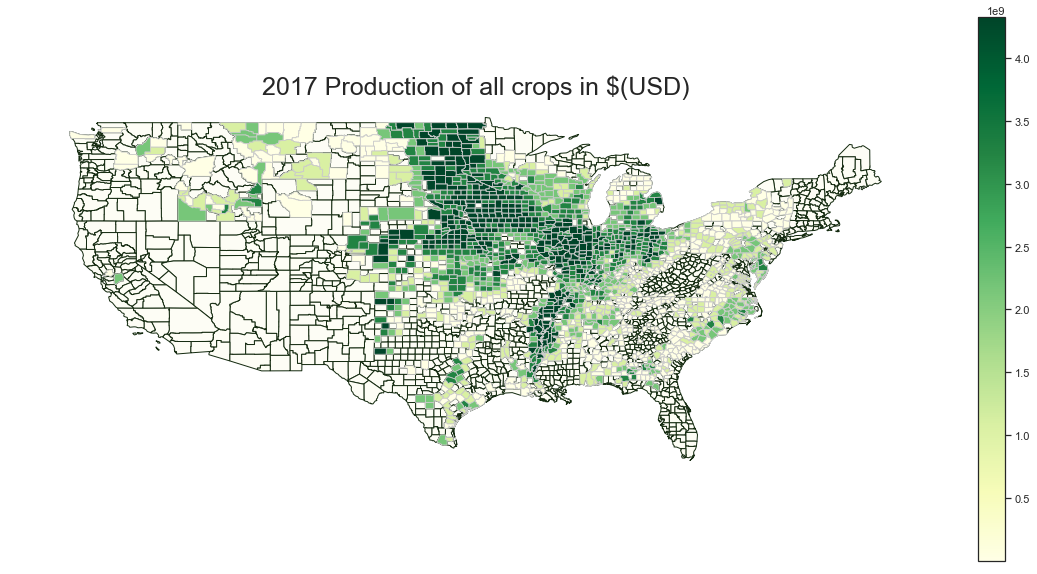

In [68]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.set_aspect('equal')
ax.axis('off')
# add a title
ax.set_title('2017 Production of all crops in \$(USD)', fontdict={'fontsize': '25', 'fontweight' : '3'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=US_counties_data['Production Value'].min(), vmax=US_counties_data['PRODUCTION'].max()))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
US_mainland_counties.plot(color='#FDFDF5', edgecolor='#162C12',ax=ax)
US_counties_data.loc[US_counties_data['Year'].dt.year==2017,:].plot(column='Production Value', cmap='YlGn', scheme='quantiles', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.show()